In [29]:
import csv
import random
import pickle
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from scipy.stats import linregress

In [45]:
vocab_size = 1000
embedding_dim = 16
max_length = 5
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"
train_split = 0.7

In [20]:
# Replace the URL with the raw URL of your CSV file
url = "https://raw.githubusercontent.com/DuitDojo-Capstone-Project/DuitDojo_ML/main/text%20classification/data.csv"

# Read the CSV file into a DataFrame
df = pd.read_csv(url)

# Display the first few rows of the DataFrame to verify the data
df.head()

,Items,Category
0,sate ayam,food
1,sari roti,food
2,black pepper meatball,food
3,bimoli,food
4,eager t-shirt,clothing


In [25]:
items_list = df['Items'].tolist()
category_list = df[' Category'].str.strip().tolist()
data_list = list(zip(items_list, category_list))
random.shuffle(data_list)
items_list, category_list = zip(*data_list)

In [30]:
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(category_list)
one_hot_labels = to_categorical(encoded_labels)

In [46]:
training_size = int(len(items_list)*train_split)
train_items = items_list[:training_size]
train_labels = one_hot_labels[:training_size]
val_items = items_list[training_size:]
val_labels = one_hot_labels[training_size:]

In [47]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_items)
train_sequences = tokenizer.texts_to_sequences(train_items)
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
val_sequences = tokenizer.texts_to_sequences(val_items)
val_padded = pad_sequences(val_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
train_labels = np.array(train_labels)
val_labels = np.array(val_labels)

In [48]:
print(len(train_padded))
print(len(train_labels))
print(len(val_padded))
print(len(val_labels))

213
213
92
92


In [92]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size,embedding_dim, input_length=max_length),
    # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50)),
    tf.keras.layers.GlobalAveragePooling1D(),
    # tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(train_padded, train_labels,
                    epochs=100,
                    validation_data=(val_padded, val_labels))

Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_38 (Embedding)    (None, 5, 16)             16000     
                                                                 
 global_average_pooling1d_3  (None, 16)                0         
 5 (GlobalAveragePooling1D)                                      
                                                                 
 dense_106 (Dense)           (None, 32)                544       
                                                                 
 dense_107 (Dense)           (None, 32)                1056      
                                                                 
 dense_108 (Dense)           (None, 5)                 165       
                                                                 
Total params: 17765 (69.39 KB)
Trainable params: 17765 (69.39 KB)
Non-trainable params: 0 (0.00 Byte)
_________________

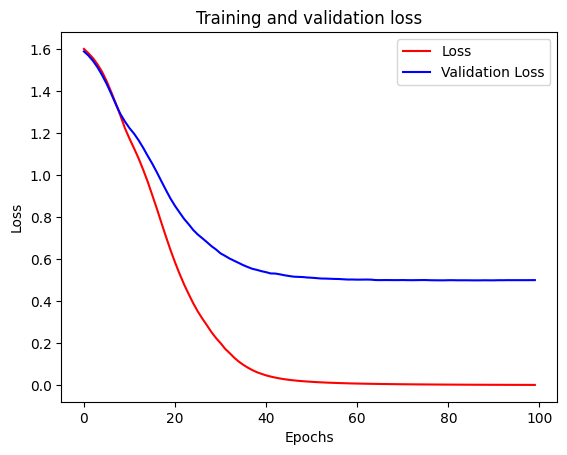

In [93]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = [*range(100)]

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])
plt.show()

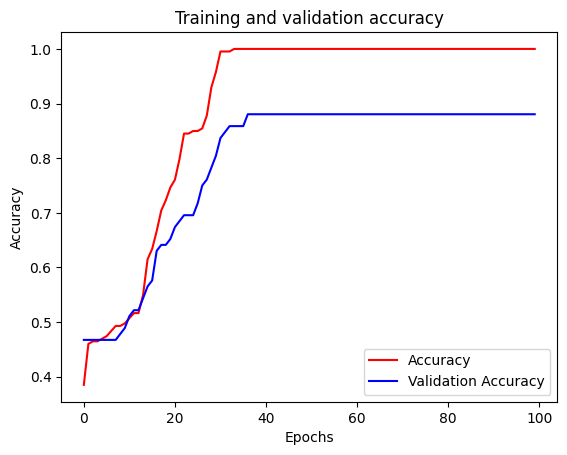

In [94]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])
plt.show()

In [95]:
slope, *_ = linregress(epochs, val_loss)
print(f"The slope of your validation loss curve is {slope:.5f}")

The slope of your validation loss curve is -0.00844


In [96]:
with open('history.pkl', 'wb') as f:
    pickle.dump(history.history, f)